In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

/home/admyyh/miniconda3/envs/ultralytics/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class PixelNorm(nn.Module):
    def __init__(self, epsilon=1e-8):
        super(PixelNorm, self).__init__()
        self.epsilon = epsilon
        
    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)

In [3]:
class MinibatchStdDev(nn.Module):
    def __init__(self):
        super(MinibatchStdDev, self).__init__()
    
    def forward(self, x):
        batch_size, _, height, width = x.shape
        # Calculate standard deviation across batch
        y = x - x.mean(dim=0, keepdim=True)
        y = torch.sqrt(y.pow(2).mean(dim=0, keepdim=False) + 1e-8)
        y = y.mean().view(1, 1, 1, 1)
        y = y.repeat(batch_size, 1, height, width)
        # Append as new channel
        return torch.cat([x, y], dim=1)

In [4]:
class PGGenerator(nn.Module):
    def __init__(self, latent_dim=512, output_channels=1):
        super(PGGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.output_channels = output_channels
        self.current_stage = 0
        self.alpha = 1.0  # Start with fully stabilized network
        
        # Initial block (7x7)
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(latent_dim, 128, 7, 1, 0),  # 7x7 output
            nn.LeakyReLU(0.2),
            PixelNorm(),
            nn.Conv2d(128, 128, 3, 1, 1),  # 7x7 maintained
            nn.LeakyReLU(0.2),
            PixelNorm()
        )
        
        # ToRGB blocks for each resolution
        self.to_rgb_blocks = nn.ModuleList([
            nn.Conv2d(128, output_channels, 1, 1, 0),  # 7x7 -> RGB
            nn.Conv2d(64, output_channels, 1, 1, 0),   # 14x14 -> RGB
            nn.Conv2d(32, output_channels, 1, 1, 0)    # 28x28 -> RGB
        ])
        
        # Upsampling blocks
        self.up_blocks = nn.ModuleList([
            # 7x7 -> 14x14
            nn.Sequential(
                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.Conv2d(128, 64, 3, 1, 1),  # 14x14
                nn.LeakyReLU(0.2),
                PixelNorm(),
                nn.Conv2d(64, 64, 3, 1, 1),   # 14x14
                nn.LeakyReLU(0.2),
                PixelNorm()
            ),
            # 14x14 -> 28x28
            nn.Sequential(
                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.Conv2d(64, 32, 3, 1, 1),   # 28x28
                nn.LeakyReLU(0.2),
                PixelNorm(),
                nn.Conv2d(32, 32, 3, 1, 1),   # 28x28
                nn.LeakyReLU(0.2),
                PixelNorm()
            )
        ])
    
    def forward(self, z):
        # Reshape latent vector to 2D
        x = z.view(z.size(0), self.latent_dim, 1, 1)
        
        # Initial block
        x = self.initial(x)
        
        # Return image based on current stage and alpha
        if self.current_stage == 0:
            # Stage 0: 7x7 resolution
            return self.to_rgb_blocks[0](x)
        else:
            # Process through upsampling blocks up to current stage
            for i in range(self.current_stage):
                features_prev = x
                x = self.up_blocks[i](x)
                
                # During transition phase for the current stage
                if i == self.current_stage - 1 and self.alpha < 1:
                    # Blend with upsampled lower resolution
                    y = F.interpolate(features_prev, scale_factor=2, mode='nearest')
                    y = self.to_rgb_blocks[i](y)
                    out = self.to_rgb_blocks[i+1](x)
                    return (1 - self.alpha) * y + self.alpha * out
            
            # After transition: use higher resolution directly
            return self.to_rgb_blocks[self.current_stage](x)
        
    def progress(self):
        """Progress to the next stage if not at final stage"""
        if self.current_stage < len(self.up_blocks):
            self.current_stage += 1
            self.alpha = 0.0  # Start transitioning from the previous stage
            
    def update_alpha(self, increment=0.1):
        """Update the alpha value for smooth transition"""
        self.alpha = min(1.0, self.alpha + increment)

In [5]:
# Progressive Discriminator
class PGDiscriminator(nn.Module):
    def __init__(self, input_channels=1):
        super(PGDiscriminator, self).__init__()
        self.input_channels = input_channels
        self.current_stage = 0
        self.alpha = 1.0  # Start with fully stabilized network
        
        # FromRGB blocks for each resolution
        self.from_rgb_blocks = nn.ModuleList([
            nn.Conv2d(input_channels, 128, 1, 1, 0),  # RGB -> 7x7 features
            nn.Conv2d(input_channels, 64, 1, 1, 0),   # RGB -> 14x14 features
            nn.Conv2d(input_channels, 32, 1, 1, 0)    # RGB -> 28x28 features
        ])
        
        # Downsampling blocks
        self.down_blocks = nn.ModuleList([
            # 14x14 -> 7x7
            nn.Sequential(
                nn.Conv2d(64, 64, 3, 1, 1),   # 14x14
                nn.LeakyReLU(0.2),
                nn.Conv2d(64, 128, 3, 1, 1),  # 14x14
                nn.LeakyReLU(0.2),
                nn.AvgPool2d(2)  # 7x7
            ),
            # 28x28 -> 14x14
            nn.Sequential(
                nn.Conv2d(32, 32, 3, 1, 1),   # 28x28
                nn.LeakyReLU(0.2),
                nn.Conv2d(32, 64, 3, 1, 1),   # 28x28
                nn.LeakyReLU(0.2),
                nn.AvgPool2d(2)  # 14x14
            ),
        ])
        
        # Final block (7x7 -> decision)
        self.final = nn.Sequential(
            MinibatchStdDev(),
            nn.Conv2d(128 + 1, 128, 3, 1, 1),  # +1 for minibatch std
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # Process based on current stage
        if self.current_stage == 0:
            # Stage 0: 7x7 resolution
            features = self.from_rgb_blocks[0](x)
            return self.final(features)
        else:
            # Start from the highest resolution
            current_res_idx = self.current_stage
            features = self.from_rgb_blocks[current_res_idx](x)
            
            # Process through downsampling blocks from highest to lowest
            for i in range(current_res_idx-1, -1, -1):
                if i == current_res_idx-1 and self.alpha < 1:
                    # During transition: blend with downsampled input
                    x_down = F.avg_pool2d(x, 2)
                    y = self.from_rgb_blocks[current_res_idx-1](x_down)
                    features = self.down_blocks[current_res_idx-1](features)
                    features = (1 - self.alpha) * y + self.alpha * features
                else:
                    # After transition: downsample features directly
                    features = self.down_blocks[i](features)
            
            # Final decision
            return self.final(features)
    
    def progress(self):
        """Progress to the next stage if not at final stage"""
        if self.current_stage < len(self.down_blocks):
            self.current_stage += 1
            self.alpha = 0.0  # Start transitioning
            
    def update_alpha(self, increment=0.1):
        """Update the alpha value for smooth transition"""
        self.alpha = min(1.0, self.alpha + increment)


In [6]:
class PGGAN(nn.Module):
    def __init__(self, latent_dim=512, input_channels=1):
        super(PGGAN, self).__init__()
        self.latent_dim = latent_dim
        self.input_channels = input_channels
        
        self.generator = PGGenerator(latent_dim, input_channels)
        self.discriminator = PGDiscriminator(input_channels)
        self.current_stage = 0
        self.resolutions = [7, 14, 28]  # Specific resolutions for MNIST
        
    def progress(self):
        """Progress both generator and discriminator to next stage"""
        if self.current_stage < len(self.resolutions) - 1:
            self.current_stage += 1
            self.generator.progress()
            self.discriminator.progress()
            print(f"Progressed to stage {self.current_stage}, resolution {self.resolutions[self.current_stage]}x{self.resolutions[self.current_stage]}")
            
    def update_alpha(self, increment=0.1):
        """Update alpha for smooth transition in both networks"""
        self.generator.update_alpha(increment)
        self.discriminator.update_alpha(increment)
    
    def get_current_resolution(self):
        """Get current resolution based on stage"""
        return self.resolutions[self.current_stage]
    
    def sample(self, n_samples=16, device='cpu'):
        """Generate samples at current resolution"""
        # Generate random noise
        z = torch.randn(n_samples, self.latent_dim).to(device)
        # Generate fake images
        with torch.no_grad():
            return self.generator(z)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# %%
# Define transforms for progressive resolutions
transform_dict = {
    7: transforms.Compose([
        transforms.Resize(7),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    14: transforms.Compose([
        transforms.Resize(14),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    28: transforms.Compose([
        transforms.ToTensor(),  # Original MNIST size
        transforms.Normalize([0.5], [0.5])
    ])
}


In [9]:
# Training parameters
latent_dim = 512
batch_sizes = {7: 128, 14: 64, 28: 32}  # Smaller batch size for higher resolution
iterations_per_stage = 5000
sample_interval = 500
alpha_update_interval = 50  # Update alpha every N iterations
transition_iterations = 2000  # Number of iterations for transition (alpha from 0 to 1)

In [10]:
# Initialize PGGAN
pggan = PGGAN(latent_dim=latent_dim, input_channels=1)
pggan.to(device)


PGGAN(
  (generator): PGGenerator(
    (initial): Sequential(
      (0): PixelNorm()
      (1): ConvTranspose2d(512, 128, kernel_size=(7, 7), stride=(1, 1))
      (2): LeakyReLU(negative_slope=0.2)
      (3): PixelNorm()
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): LeakyReLU(negative_slope=0.2)
      (6): PixelNorm()
    )
    (to_rgb_blocks): ModuleList(
      (0): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
      (2): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
    )
    (up_blocks): ModuleList(
      (0): Sequential(
        (0): Upsample(scale_factor=2.0, mode='nearest')
        (1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): LeakyReLU(negative_slope=0.2)
        (3): PixelNorm()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): LeakyReLU(negative_slope=0.2)
        (6): PixelNorm()
      )

In [11]:
# Loss function
adversarial_loss = nn.BCELoss()

# %%
# Training loop with progressive growing
# Optimizers
optimizer_G = optim.Adam(pggan.generator.parameters(), lr=0.0001, betas=(0.0, 0.99))
optimizer_D = optim.Adam(pggan.discriminator.parameters(), lr=0.0001, betas=(0.0, 0.99))


Starting training at resolution 7x7
Stage 0, Resolution 7x7, Iteration 0/5000, Alpha: 1.000, D Loss: 0.6928, G Loss: 0.6828


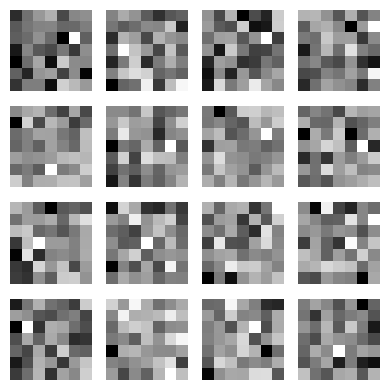

Stage 0, Resolution 7x7, Iteration 100/5000, Alpha: 1.000, D Loss: 0.6184, G Loss: 0.6698
Stage 0, Resolution 7x7, Iteration 200/5000, Alpha: 1.000, D Loss: 0.6666, G Loss: 0.6348
Stage 0, Resolution 7x7, Iteration 300/5000, Alpha: 1.000, D Loss: 0.6022, G Loss: 0.6953
Stage 0, Resolution 7x7, Iteration 400/5000, Alpha: 1.000, D Loss: 0.6766, G Loss: 0.5689
Stage 0, Resolution 7x7, Iteration 500/5000, Alpha: 1.000, D Loss: 0.6098, G Loss: 0.5787


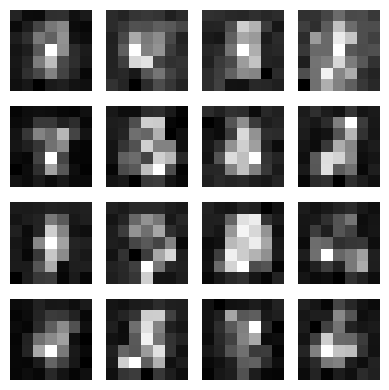

Stage 0, Resolution 7x7, Iteration 600/5000, Alpha: 1.000, D Loss: 0.6486, G Loss: 1.1312
Stage 0, Resolution 7x7, Iteration 700/5000, Alpha: 1.000, D Loss: 0.5477, G Loss: 0.5697
Stage 0, Resolution 7x7, Iteration 800/5000, Alpha: 1.000, D Loss: 0.6225, G Loss: 0.6360
Stage 0, Resolution 7x7, Iteration 900/5000, Alpha: 1.000, D Loss: 0.8117, G Loss: 1.5868
Stage 0, Resolution 7x7, Iteration 1000/5000, Alpha: 1.000, D Loss: 0.6936, G Loss: 1.3711


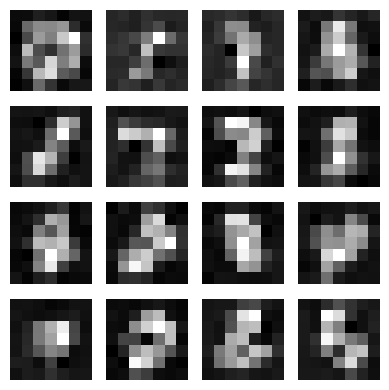

Stage 0, Resolution 7x7, Iteration 1100/5000, Alpha: 1.000, D Loss: 0.6235, G Loss: 1.0074
Stage 0, Resolution 7x7, Iteration 1200/5000, Alpha: 1.000, D Loss: 0.5734, G Loss: 0.7378
Stage 0, Resolution 7x7, Iteration 1300/5000, Alpha: 1.000, D Loss: 0.6046, G Loss: 1.4162
Stage 0, Resolution 7x7, Iteration 1400/5000, Alpha: 1.000, D Loss: 0.6742, G Loss: 1.4871
Stage 0, Resolution 7x7, Iteration 1500/5000, Alpha: 1.000, D Loss: 0.6213, G Loss: 0.4909


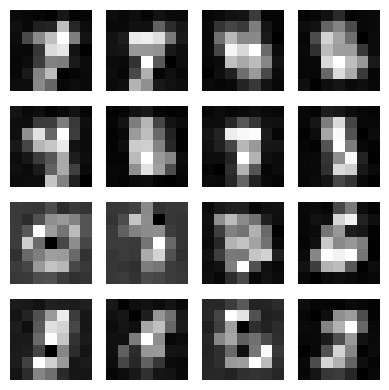

Stage 0, Resolution 7x7, Iteration 1600/5000, Alpha: 1.000, D Loss: 0.6223, G Loss: 0.8984
Stage 0, Resolution 7x7, Iteration 1700/5000, Alpha: 1.000, D Loss: 0.5671, G Loss: 0.6093
Stage 0, Resolution 7x7, Iteration 1800/5000, Alpha: 1.000, D Loss: 0.6568, G Loss: 1.1779
Stage 0, Resolution 7x7, Iteration 1900/5000, Alpha: 1.000, D Loss: 0.6010, G Loss: 0.5814
Stage 0, Resolution 7x7, Iteration 2000/5000, Alpha: 1.000, D Loss: 0.6461, G Loss: 1.1491


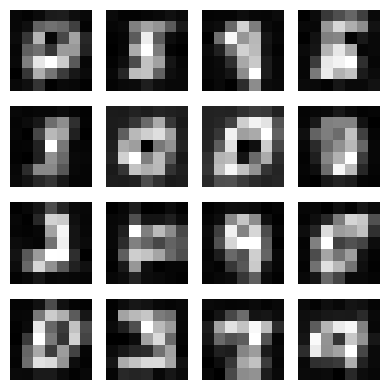

Stage 0, Resolution 7x7, Iteration 2100/5000, Alpha: 1.000, D Loss: 0.6009, G Loss: 0.5828
Stage 0, Resolution 7x7, Iteration 2200/5000, Alpha: 1.000, D Loss: 0.6046, G Loss: 0.5805
Stage 0, Resolution 7x7, Iteration 2300/5000, Alpha: 1.000, D Loss: 0.6942, G Loss: 1.3637
Stage 0, Resolution 7x7, Iteration 2400/5000, Alpha: 1.000, D Loss: 0.6210, G Loss: 0.6630
Stage 0, Resolution 7x7, Iteration 2500/5000, Alpha: 1.000, D Loss: 0.6535, G Loss: 0.5496


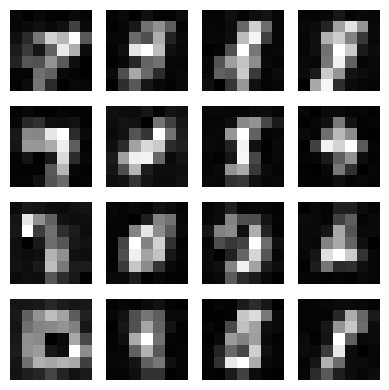

Stage 0, Resolution 7x7, Iteration 2600/5000, Alpha: 1.000, D Loss: 0.7206, G Loss: 1.2952
Stage 0, Resolution 7x7, Iteration 2700/5000, Alpha: 1.000, D Loss: 0.4980, G Loss: 0.7521
Stage 0, Resolution 7x7, Iteration 2800/5000, Alpha: 1.000, D Loss: 0.6174, G Loss: 0.8167
Stage 0, Resolution 7x7, Iteration 2900/5000, Alpha: 1.000, D Loss: 0.5267, G Loss: 0.7104
Stage 0, Resolution 7x7, Iteration 3000/5000, Alpha: 1.000, D Loss: 0.5251, G Loss: 0.6683


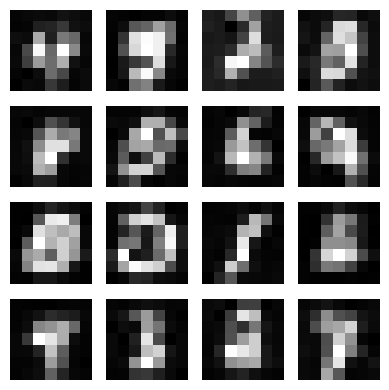

Stage 0, Resolution 7x7, Iteration 3100/5000, Alpha: 1.000, D Loss: 0.5489, G Loss: 0.6228
Stage 0, Resolution 7x7, Iteration 3200/5000, Alpha: 1.000, D Loss: 0.5069, G Loss: 0.7560
Stage 0, Resolution 7x7, Iteration 3300/5000, Alpha: 1.000, D Loss: 0.5307, G Loss: 0.7147
Stage 0, Resolution 7x7, Iteration 3400/5000, Alpha: 1.000, D Loss: 0.5569, G Loss: 0.6756
Stage 0, Resolution 7x7, Iteration 3500/5000, Alpha: 1.000, D Loss: 0.4961, G Loss: 0.7157


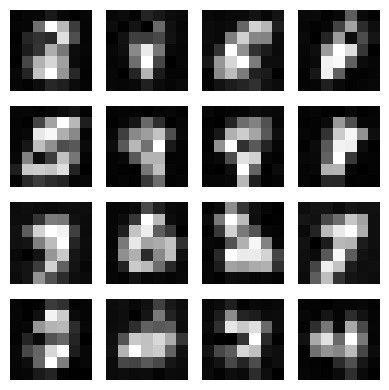

Stage 0, Resolution 7x7, Iteration 3600/5000, Alpha: 1.000, D Loss: 0.4880, G Loss: 0.7579
Stage 0, Resolution 7x7, Iteration 3700/5000, Alpha: 1.000, D Loss: 0.5482, G Loss: 0.6859
Stage 0, Resolution 7x7, Iteration 3800/5000, Alpha: 1.000, D Loss: 0.5648, G Loss: 0.6574
Stage 0, Resolution 7x7, Iteration 3900/5000, Alpha: 1.000, D Loss: 0.4929, G Loss: 0.7945
Stage 0, Resolution 7x7, Iteration 4000/5000, Alpha: 1.000, D Loss: 0.5682, G Loss: 0.6407


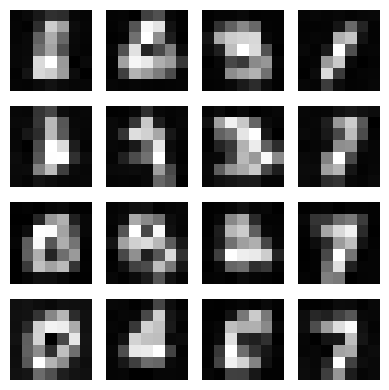

Stage 0, Resolution 7x7, Iteration 4100/5000, Alpha: 1.000, D Loss: 0.4834, G Loss: 0.7577
Stage 0, Resolution 7x7, Iteration 4200/5000, Alpha: 1.000, D Loss: 0.4288, G Loss: 0.8922
Stage 0, Resolution 7x7, Iteration 4300/5000, Alpha: 1.000, D Loss: 0.4969, G Loss: 0.7436
Stage 0, Resolution 7x7, Iteration 4400/5000, Alpha: 1.000, D Loss: 0.4910, G Loss: 0.7162
Stage 0, Resolution 7x7, Iteration 4500/5000, Alpha: 1.000, D Loss: 0.4404, G Loss: 0.8412


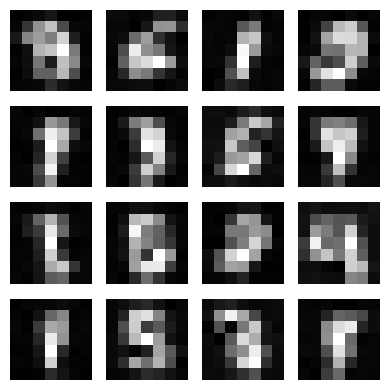

Stage 0, Resolution 7x7, Iteration 4600/5000, Alpha: 1.000, D Loss: 0.4593, G Loss: 0.8050
Stage 0, Resolution 7x7, Iteration 4700/5000, Alpha: 1.000, D Loss: 0.4874, G Loss: 0.7605
Stage 0, Resolution 7x7, Iteration 4800/5000, Alpha: 1.000, D Loss: 0.5034, G Loss: 0.7920
Stage 0, Resolution 7x7, Iteration 4900/5000, Alpha: 1.000, D Loss: 0.5136, G Loss: 0.7665
Progressed to stage 1, resolution 14x14
Starting training at resolution 14x14
Stage 1, Resolution 14x14, Iteration 0/5000, Alpha: 0.025, D Loss: 0.5468, G Loss: 0.7865


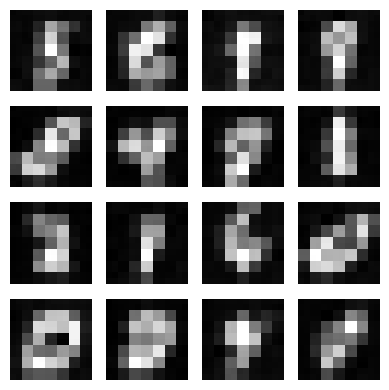

Stage 1, Resolution 14x14, Iteration 100/5000, Alpha: 0.075, D Loss: 0.4913, G Loss: 1.1071
Stage 1, Resolution 14x14, Iteration 200/5000, Alpha: 0.125, D Loss: 0.5206, G Loss: 1.1091
Stage 1, Resolution 14x14, Iteration 300/5000, Alpha: 0.175, D Loss: 0.6217, G Loss: 1.6042
Stage 1, Resolution 14x14, Iteration 400/5000, Alpha: 0.225, D Loss: 0.5773, G Loss: 1.2507
Stage 1, Resolution 14x14, Iteration 500/5000, Alpha: 0.275, D Loss: 0.5573, G Loss: 0.8527


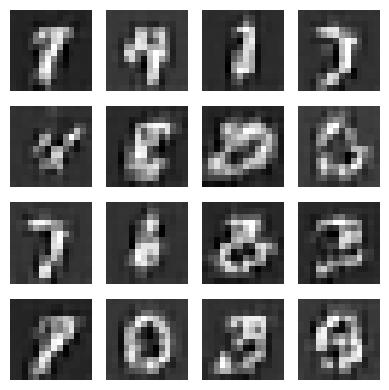

Stage 1, Resolution 14x14, Iteration 600/5000, Alpha: 0.325, D Loss: 0.5937, G Loss: 0.8302
Stage 1, Resolution 14x14, Iteration 700/5000, Alpha: 0.375, D Loss: 0.5523, G Loss: 0.8264
Stage 1, Resolution 14x14, Iteration 800/5000, Alpha: 0.425, D Loss: 0.6606, G Loss: 0.5237
Stage 1, Resolution 14x14, Iteration 900/5000, Alpha: 0.475, D Loss: 0.5938, G Loss: 0.7037
Stage 1, Resolution 14x14, Iteration 1000/5000, Alpha: 0.525, D Loss: 0.5633, G Loss: 0.8837


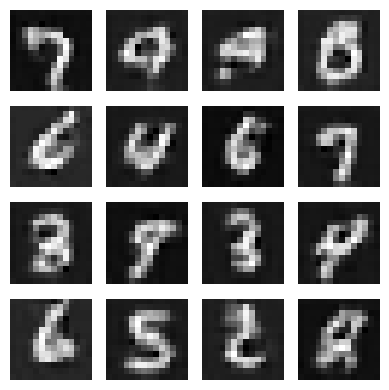

Stage 1, Resolution 14x14, Iteration 1100/5000, Alpha: 0.575, D Loss: 0.5390, G Loss: 0.9236
Stage 1, Resolution 14x14, Iteration 1200/5000, Alpha: 0.625, D Loss: 0.6798, G Loss: 0.9521
Stage 1, Resolution 14x14, Iteration 1300/5000, Alpha: 0.675, D Loss: 0.6293, G Loss: 0.7576
Stage 1, Resolution 14x14, Iteration 1400/5000, Alpha: 0.725, D Loss: 0.6310, G Loss: 1.1740
Stage 1, Resolution 14x14, Iteration 1500/5000, Alpha: 0.775, D Loss: 0.6104, G Loss: 1.3868


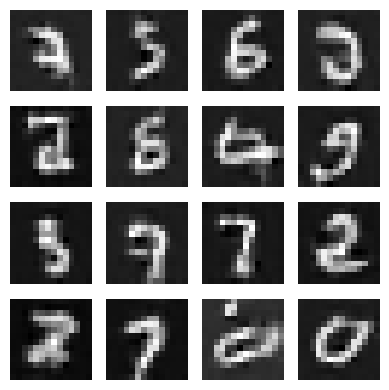

Stage 1, Resolution 14x14, Iteration 1600/5000, Alpha: 0.825, D Loss: 0.6584, G Loss: 0.7776
Stage 1, Resolution 14x14, Iteration 1700/5000, Alpha: 0.875, D Loss: 0.6416, G Loss: 0.6917
Stage 1, Resolution 14x14, Iteration 1800/5000, Alpha: 0.925, D Loss: 0.5702, G Loss: 0.7750
Stage 1, Resolution 14x14, Iteration 1900/5000, Alpha: 0.975, D Loss: 0.6579, G Loss: 0.8747
Stage 1, Resolution 14x14, Iteration 2000/5000, Alpha: 1.000, D Loss: 0.5437, G Loss: 0.7108


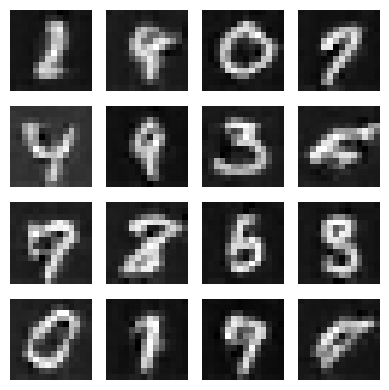

Stage 1, Resolution 14x14, Iteration 2100/5000, Alpha: 1.000, D Loss: 0.6336, G Loss: 1.0363
Stage 1, Resolution 14x14, Iteration 2200/5000, Alpha: 1.000, D Loss: 0.6053, G Loss: 0.7018
Stage 1, Resolution 14x14, Iteration 2300/5000, Alpha: 1.000, D Loss: 0.6074, G Loss: 0.8114
Stage 1, Resolution 14x14, Iteration 2400/5000, Alpha: 1.000, D Loss: 0.6779, G Loss: 1.0984
Stage 1, Resolution 14x14, Iteration 2500/5000, Alpha: 1.000, D Loss: 0.6917, G Loss: 1.3736


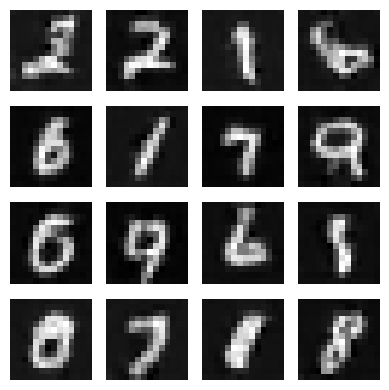

Stage 1, Resolution 14x14, Iteration 2600/5000, Alpha: 1.000, D Loss: 0.6237, G Loss: 0.6799
Stage 1, Resolution 14x14, Iteration 2700/5000, Alpha: 1.000, D Loss: 0.6528, G Loss: 0.7274
Stage 1, Resolution 14x14, Iteration 2800/5000, Alpha: 1.000, D Loss: 0.6358, G Loss: 0.8590
Stage 1, Resolution 14x14, Iteration 2900/5000, Alpha: 1.000, D Loss: 0.6278, G Loss: 0.8376
Stage 1, Resolution 14x14, Iteration 3000/5000, Alpha: 1.000, D Loss: 0.6139, G Loss: 0.7683


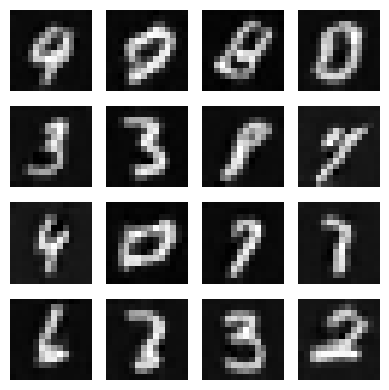

Stage 1, Resolution 14x14, Iteration 3100/5000, Alpha: 1.000, D Loss: 0.6178, G Loss: 0.7992
Stage 1, Resolution 14x14, Iteration 3200/5000, Alpha: 1.000, D Loss: 0.5957, G Loss: 1.7470
Stage 1, Resolution 14x14, Iteration 3300/5000, Alpha: 1.000, D Loss: 0.5887, G Loss: 0.9018
Stage 1, Resolution 14x14, Iteration 3400/5000, Alpha: 1.000, D Loss: 0.5899, G Loss: 0.9175
Stage 1, Resolution 14x14, Iteration 3500/5000, Alpha: 1.000, D Loss: 0.6105, G Loss: 0.8811


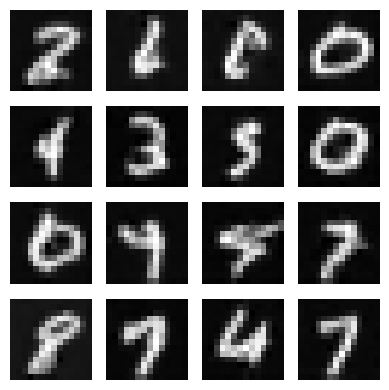

Stage 1, Resolution 14x14, Iteration 3600/5000, Alpha: 1.000, D Loss: 0.5838, G Loss: 0.9043
Stage 1, Resolution 14x14, Iteration 3700/5000, Alpha: 1.000, D Loss: 0.6312, G Loss: 1.1686
Stage 1, Resolution 14x14, Iteration 3800/5000, Alpha: 1.000, D Loss: 0.5942, G Loss: 0.9920
Stage 1, Resolution 14x14, Iteration 3900/5000, Alpha: 1.000, D Loss: 0.6318, G Loss: 0.8494
Stage 1, Resolution 14x14, Iteration 4000/5000, Alpha: 1.000, D Loss: 0.6293, G Loss: 0.9336


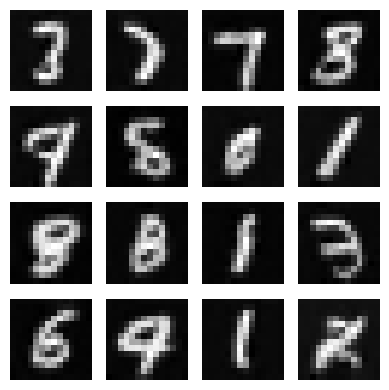

Stage 1, Resolution 14x14, Iteration 4100/5000, Alpha: 1.000, D Loss: 0.6532, G Loss: 0.8108
Stage 1, Resolution 14x14, Iteration 4200/5000, Alpha: 1.000, D Loss: 0.6174, G Loss: 0.7657
Stage 1, Resolution 14x14, Iteration 4300/5000, Alpha: 1.000, D Loss: 0.6199, G Loss: 0.9906
Stage 1, Resolution 14x14, Iteration 4400/5000, Alpha: 1.000, D Loss: 0.6371, G Loss: 0.9473
Stage 1, Resolution 14x14, Iteration 4500/5000, Alpha: 1.000, D Loss: 0.6081, G Loss: 1.2216


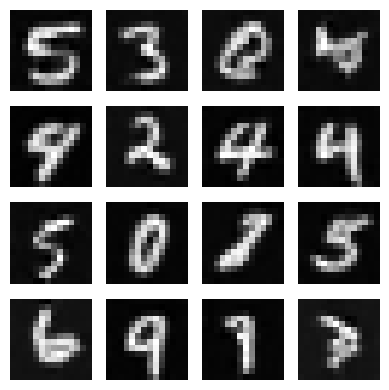

Stage 1, Resolution 14x14, Iteration 4600/5000, Alpha: 1.000, D Loss: 0.6062, G Loss: 0.6087
Stage 1, Resolution 14x14, Iteration 4700/5000, Alpha: 1.000, D Loss: 0.6177, G Loss: 0.8878
Stage 1, Resolution 14x14, Iteration 4800/5000, Alpha: 1.000, D Loss: 0.6126, G Loss: 0.6881
Stage 1, Resolution 14x14, Iteration 4900/5000, Alpha: 1.000, D Loss: 0.6397, G Loss: 0.7637
Progressed to stage 2, resolution 28x28
Starting training at resolution 28x28
Stage 2, Resolution 28x28, Iteration 0/5000, Alpha: 0.025, D Loss: 1.0148, G Loss: 0.8609


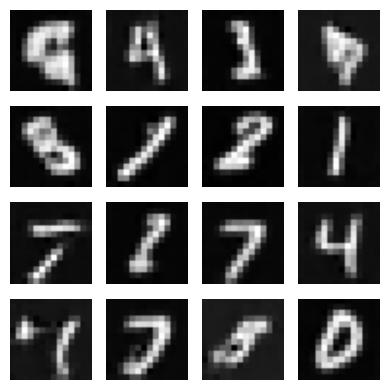

Stage 2, Resolution 28x28, Iteration 100/5000, Alpha: 0.075, D Loss: 0.5870, G Loss: 0.7496
Stage 2, Resolution 28x28, Iteration 200/5000, Alpha: 0.125, D Loss: 0.6254, G Loss: 0.8575
Stage 2, Resolution 28x28, Iteration 300/5000, Alpha: 0.175, D Loss: 0.6270, G Loss: 0.8444
Stage 2, Resolution 28x28, Iteration 400/5000, Alpha: 0.225, D Loss: 0.6787, G Loss: 0.7753
Stage 2, Resolution 28x28, Iteration 500/5000, Alpha: 0.275, D Loss: 0.6517, G Loss: 0.9289


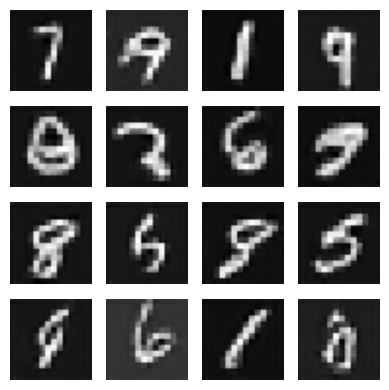

Stage 2, Resolution 28x28, Iteration 600/5000, Alpha: 0.325, D Loss: 0.6285, G Loss: 0.8042
Stage 2, Resolution 28x28, Iteration 700/5000, Alpha: 0.375, D Loss: 0.6354, G Loss: 0.8584
Stage 2, Resolution 28x28, Iteration 800/5000, Alpha: 0.425, D Loss: 0.6303, G Loss: 0.7416
Stage 2, Resolution 28x28, Iteration 900/5000, Alpha: 0.475, D Loss: 0.5758, G Loss: 0.8225
Stage 2, Resolution 28x28, Iteration 1000/5000, Alpha: 0.525, D Loss: 0.6286, G Loss: 0.8816


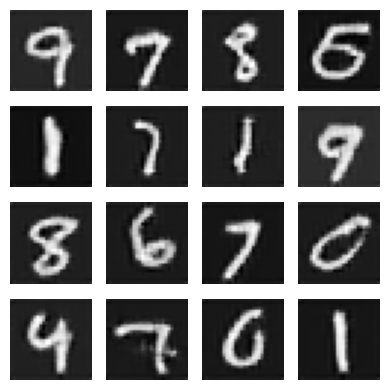

Stage 2, Resolution 28x28, Iteration 1100/5000, Alpha: 0.575, D Loss: 0.6153, G Loss: 0.8256
Stage 2, Resolution 28x28, Iteration 1200/5000, Alpha: 0.625, D Loss: 0.6269, G Loss: 0.9011
Stage 2, Resolution 28x28, Iteration 1300/5000, Alpha: 0.675, D Loss: 0.7111, G Loss: 0.7723
Stage 2, Resolution 28x28, Iteration 1400/5000, Alpha: 0.725, D Loss: 0.6758, G Loss: 0.7508
Stage 2, Resolution 28x28, Iteration 1500/5000, Alpha: 0.775, D Loss: 0.6068, G Loss: 0.9037


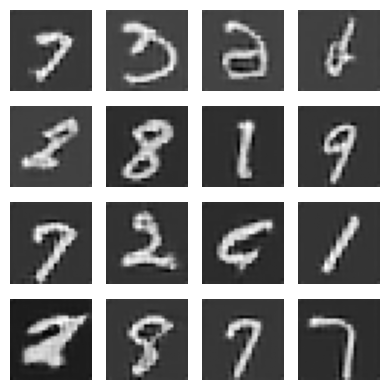

Stage 2, Resolution 28x28, Iteration 1600/5000, Alpha: 0.825, D Loss: 0.6096, G Loss: 0.9318
Stage 2, Resolution 28x28, Iteration 1700/5000, Alpha: 0.875, D Loss: 0.6794, G Loss: 0.6587
Stage 2, Resolution 28x28, Iteration 1800/5000, Alpha: 0.925, D Loss: 0.6160, G Loss: 0.7716
Stage 2, Resolution 28x28, Iteration 1900/5000, Alpha: 0.975, D Loss: 0.6211, G Loss: 0.9147
Stage 2, Resolution 28x28, Iteration 2000/5000, Alpha: 1.000, D Loss: 0.6094, G Loss: 0.8829


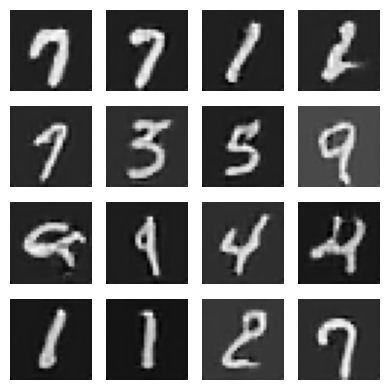

Stage 2, Resolution 28x28, Iteration 2100/5000, Alpha: 1.000, D Loss: 0.6889, G Loss: 0.9228
Stage 2, Resolution 28x28, Iteration 2200/5000, Alpha: 1.000, D Loss: 0.6979, G Loss: 0.5708
Stage 2, Resolution 28x28, Iteration 2300/5000, Alpha: 1.000, D Loss: 0.6461, G Loss: 0.6282
Stage 2, Resolution 28x28, Iteration 2400/5000, Alpha: 1.000, D Loss: 0.6426, G Loss: 0.8492
Stage 2, Resolution 28x28, Iteration 2500/5000, Alpha: 1.000, D Loss: 0.5653, G Loss: 0.8582


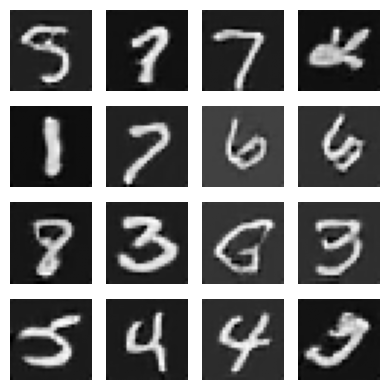

Stage 2, Resolution 28x28, Iteration 2600/5000, Alpha: 1.000, D Loss: 0.6556, G Loss: 0.8282
Stage 2, Resolution 28x28, Iteration 2700/5000, Alpha: 1.000, D Loss: 0.6615, G Loss: 0.6803
Stage 2, Resolution 28x28, Iteration 2800/5000, Alpha: 1.000, D Loss: 0.6837, G Loss: 0.9916
Stage 2, Resolution 28x28, Iteration 2900/5000, Alpha: 1.000, D Loss: 0.5930, G Loss: 0.8519
Stage 2, Resolution 28x28, Iteration 3000/5000, Alpha: 1.000, D Loss: 0.6984, G Loss: 0.8393


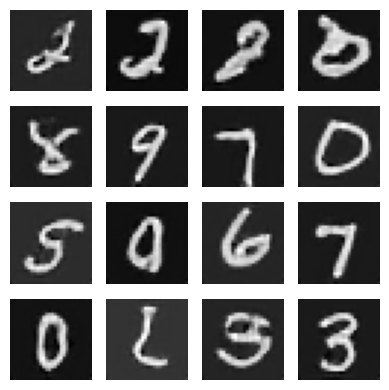

Stage 2, Resolution 28x28, Iteration 3100/5000, Alpha: 1.000, D Loss: 0.6203, G Loss: 0.7151
Stage 2, Resolution 28x28, Iteration 3200/5000, Alpha: 1.000, D Loss: 0.6938, G Loss: 1.0945
Stage 2, Resolution 28x28, Iteration 3300/5000, Alpha: 1.000, D Loss: 0.6748, G Loss: 0.8037
Stage 2, Resolution 28x28, Iteration 3400/5000, Alpha: 1.000, D Loss: 0.6864, G Loss: 0.8138
Stage 2, Resolution 28x28, Iteration 3500/5000, Alpha: 1.000, D Loss: 0.6161, G Loss: 0.7099


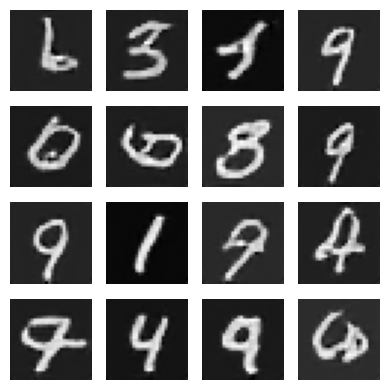

Stage 2, Resolution 28x28, Iteration 3600/5000, Alpha: 1.000, D Loss: 0.6691, G Loss: 0.6937
Stage 2, Resolution 28x28, Iteration 3700/5000, Alpha: 1.000, D Loss: 0.6621, G Loss: 0.7345
Stage 2, Resolution 28x28, Iteration 3800/5000, Alpha: 1.000, D Loss: 0.6314, G Loss: 0.5584
Stage 2, Resolution 28x28, Iteration 3900/5000, Alpha: 1.000, D Loss: 0.6131, G Loss: 0.6334
Stage 2, Resolution 28x28, Iteration 4000/5000, Alpha: 1.000, D Loss: 0.6341, G Loss: 0.5178


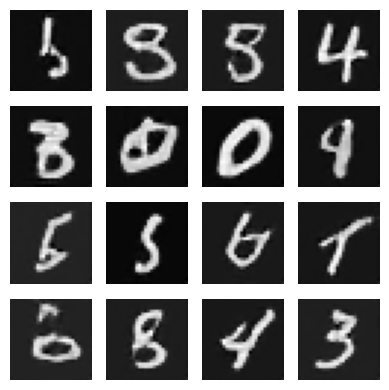

Stage 2, Resolution 28x28, Iteration 4100/5000, Alpha: 1.000, D Loss: 0.6364, G Loss: 0.7545
Stage 2, Resolution 28x28, Iteration 4200/5000, Alpha: 1.000, D Loss: 0.6426, G Loss: 0.7256
Stage 2, Resolution 28x28, Iteration 4300/5000, Alpha: 1.000, D Loss: 0.6890, G Loss: 0.6346
Stage 2, Resolution 28x28, Iteration 4400/5000, Alpha: 1.000, D Loss: 0.6278, G Loss: 0.8722
Stage 2, Resolution 28x28, Iteration 4500/5000, Alpha: 1.000, D Loss: 0.6064, G Loss: 1.0053


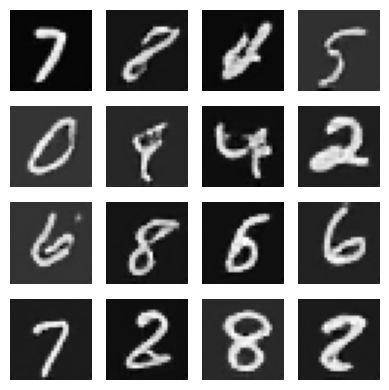

Stage 2, Resolution 28x28, Iteration 4600/5000, Alpha: 1.000, D Loss: 0.5750, G Loss: 1.1442
Stage 2, Resolution 28x28, Iteration 4700/5000, Alpha: 1.000, D Loss: 0.6222, G Loss: 0.9930
Stage 2, Resolution 28x28, Iteration 4800/5000, Alpha: 1.000, D Loss: 0.4993, G Loss: 0.7963
Stage 2, Resolution 28x28, Iteration 4900/5000, Alpha: 1.000, D Loss: 0.6144, G Loss: 0.5572


In [12]:
# Training for each stage
for stage in range(0, 3):  # Three stages: 7x7, 14x14, and 28x28
    # Set current stage if not already set
    if pggan.current_stage != stage:
        pggan.current_stage = stage
        pggan.generator.current_stage = stage
        pggan.discriminator.current_stage = stage
    
    resolution = pggan.get_current_resolution()
    print(f"Starting training at resolution {resolution}x{resolution}")
    
    # Create dataset for current resolution
    train_dataset = datasets.MNIST(
        root='./data', 
        train=True, 
        download=True, 
        transform=transform_dict[resolution]
    )
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_sizes[resolution], 
        shuffle=True,
        num_workers=4,
        drop_last=True
    )
    
    # Create infinite data loader
    data_iter = iter(train_loader)
    
    # Training loop for current stage
    for iteration in range(iterations_per_stage):
        # Get batch (restart if we've gone through the dataset)
        try:
            real_imgs, _ = next(data_iter)
        except StopIteration:
            data_iter = iter(train_loader)
            real_imgs, _ = next(data_iter)
            
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        
        # Create labels
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)
        
        # -----------------
        # Train Generator
        # -----------------
        optimizer_G.zero_grad()
        
        # Generate noise
        z = torch.randn(batch_size, latent_dim).to(device)
        
        # Generate fake images
        gen_imgs = pggan.generator(z)
        
        # Try to fool the discriminator
        g_loss = adversarial_loss(pggan.discriminator(gen_imgs), valid)
        
        g_loss.backward()
        optimizer_G.step()
        
        # -----------------
        # Train Discriminator
        # -----------------
        optimizer_D.zero_grad()
        
        # Measure discriminator's ability to classify real images
        real_loss = adversarial_loss(pggan.discriminator(real_imgs), valid)
        
        # Measure discriminator's ability to classify fake images
        fake_loss = adversarial_loss(pggan.discriminator(gen_imgs.detach()), fake)
        
        d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()
        optimizer_D.step()
        
        # Update alpha value during transition phase
        if stage > 0 and iteration < transition_iterations and iteration % alpha_update_interval == 0:
            alpha_increment = 1.0 / (transition_iterations / alpha_update_interval)
            pggan.update_alpha(alpha_increment)
        
        # Print progress
        if iteration % 100 == 0:
            print(f"Stage {stage}, Resolution {resolution}x{resolution}, Iteration {iteration}/{iterations_per_stage}, Alpha: {pggan.generator.alpha:.3f}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
        
        # Save generated samples at intervals
        if iteration % sample_interval == 0:
            # Generate samples
            with torch.no_grad():
                samples = pggan.sample(16, device)
                # Denormalize samples
                samples = (samples * 0.5) + 0.5
                
                # Plot samples
                plt.figure(figsize=(4, 4))
                for j in range(16):
                    plt.subplot(4, 4, j + 1)
                    plt.imshow(samples[j].cpu().squeeze().numpy(), cmap='gray')
                    plt.axis('off')
                plt.tight_layout()
                plt.show()
    
    # Progress to next stage (if not the final stage)
    if stage < 2:  # We have 3 stages (0, 1, 2)
        pggan.progress()
        # Reset optimizers for next stage with adjusted learning rate
        optimizer_G = optim.Adam(pggan.generator.parameters(), lr=0.0001 * (0.5 ** stage), betas=(0.0, 0.99))
        optimizer_D = optim.Adam(pggan.discriminator.parameters(), lr=0.0001 * (0.5 ** stage), betas=(0.0, 0.99))


In [13]:

with torch.no_grad():
    pggan.generator.eval()
    samples = pggan.sample(16, device)
    # Denormalize samples
    samples = (samples * 0.5) + 0.5
    
    # Plot samples
    plt.figure(figsize=(4, 4))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(samples[i].cpu().squeeze().numpy(), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('pggan_final_samples.png')
    plt.close()


In [14]:
# Save model
torch.save({
    'generator_state_dict': pggan.generator.state_dict(),
    'discriminator_state_dict': pggan.discriminator.state_dict(),
    'current_stage': pggan.current_stage
}, 'pggan_model.pth')


In [15]:
# Function to load and use the model
def load_and_generate(model_path, num_samples=16, device='cpu'):
    # Initialize a new model
    pggan = PGGAN(latent_dim=512, input_channels=1).to(device)
    
    # Load the saved model
    checkpoint = torch.load(model_path, map_location=device)
    pggan.generator.load_state_dict(checkpoint['generator_state_dict'])
    pggan.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    pggan.current_stage = checkpoint['current_stage']
    pggan.generator.current_stage = pggan.current_stage
    pggan.discriminator.current_stage = pggan.current_stage
    
    # Generate samples
    with torch.no_grad():
        pggan.generator.eval()
        samples = pggan.sample(num_samples, device)
        samples = (samples * 0.5) + 0.5
    
    return samples

# %%
